## Lecture learning goals

By the end of the lecture you will be able to:

1. Create dash tables
2. Use interactive dash table components in callbacks

# Dash tables

## Creating tables with pagination, filters and sorting

Dash has tables that can filter and sort data,
as well as send and respond to signals.
let's see how to create them!

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
            ),
        ])
    ])
)

if __name__ == '__main__':
    app.run_server(debug=True)
```

We only pass the five first columns of the data frame to make it a bit easier to look at for our purposes.
In general,
we probably don't want to display massive amounts of data in this manner anyways.

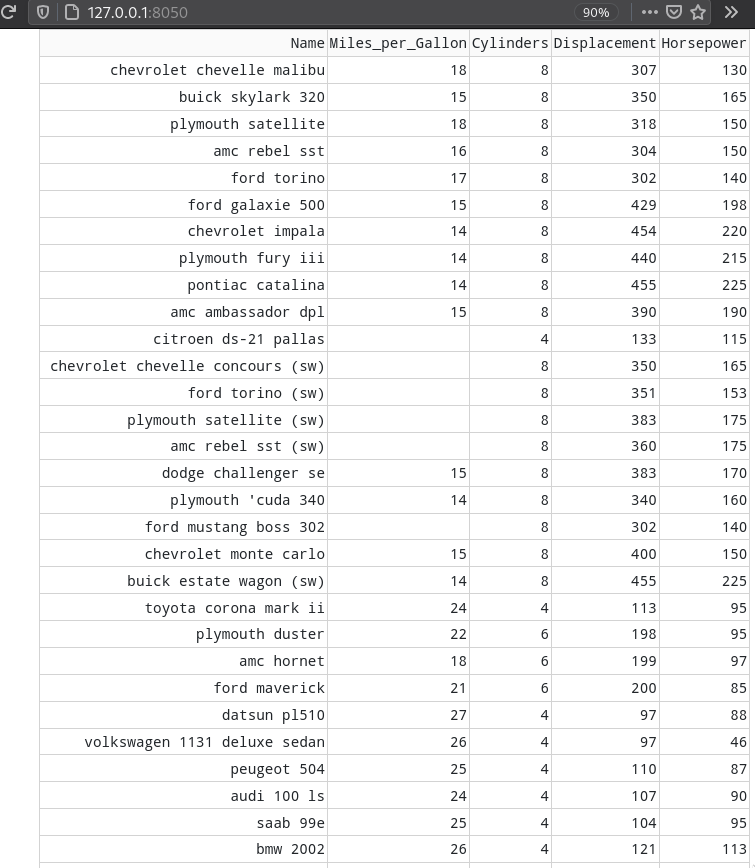

Instead of viewing all the data in one long table,
we can enable pagination by specifying e.g. `page_size=10`.

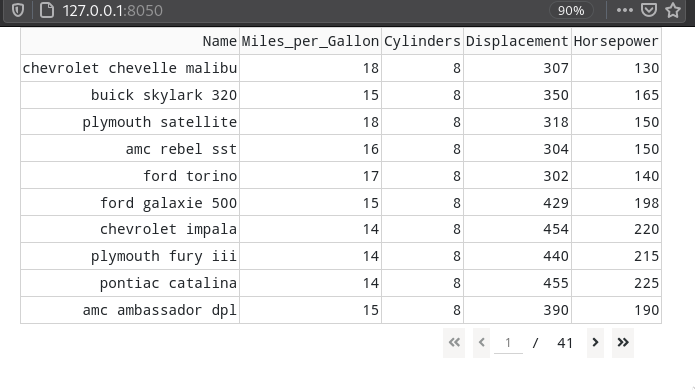

We can enable sorting by setting `sort_action='native'`,
which gives us small arrows to the click on the left side of each column header.

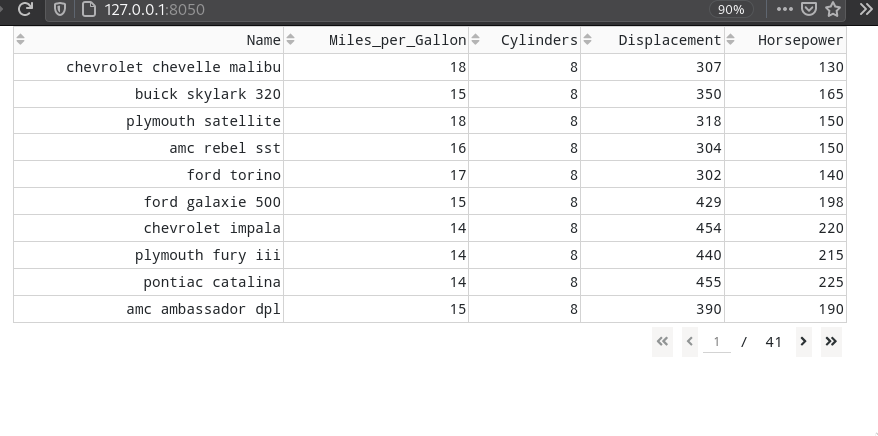

Filtering can be enabled in the same manner 
by setting `filter_action='native'`.
[Dash has it own filter syntax](https://dash.plotly.com/datatable/filtering),
which is similar to what we have used previously with dataframes.

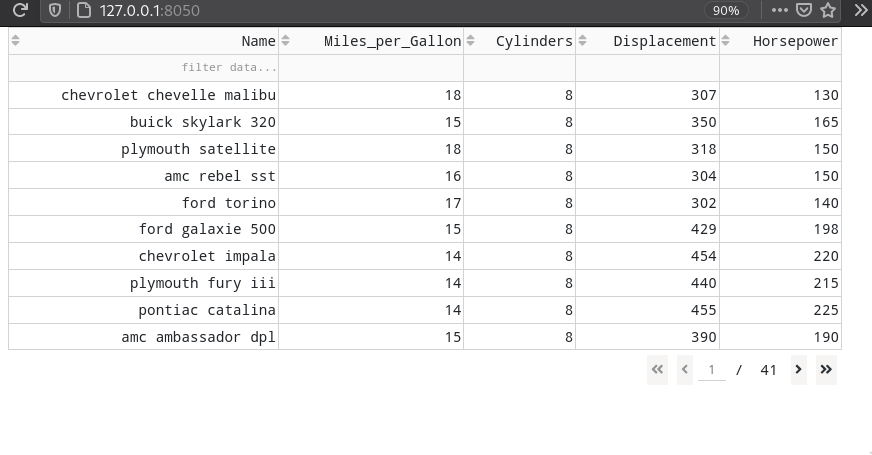

To make columns selectable
with a radio button,
we need to add three lines
(also showing how to avoid making all columns selectable,
we're skipping `'name'` here:

```python
columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]],  
column_selectable="single",
selected_columns=['Miles_per_Gallon'], 
```
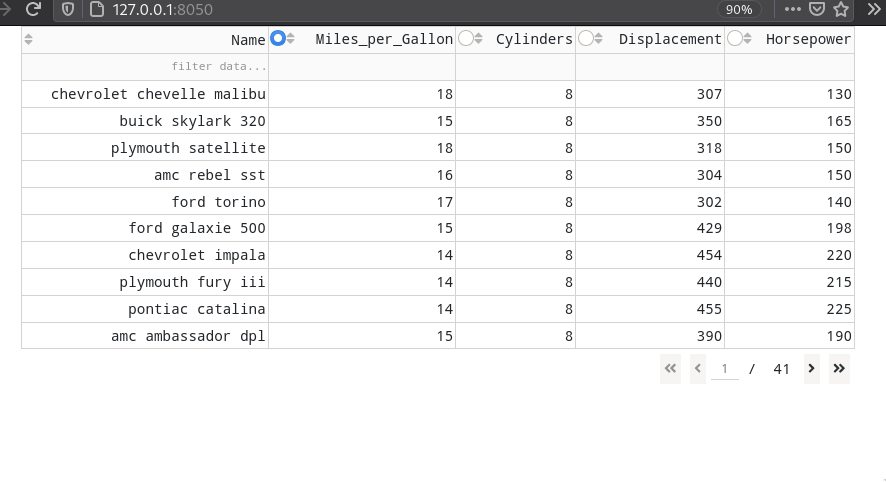

Finally,
we can make our table a bit prettier
by styling it with the following segment,
which color the rows in alternating dark and light colors.

```python
style_cell={'padding': '5px'},
style_data_conditional=[{
    'if': {'row_index': 'odd'},
    'backgroundColor': 'rgb(248, 248, 248)'}],
 style_header={
    'backgroundColor': 'rgb(230, 230, 230)',
    'fontWeight': 'bold'}
```


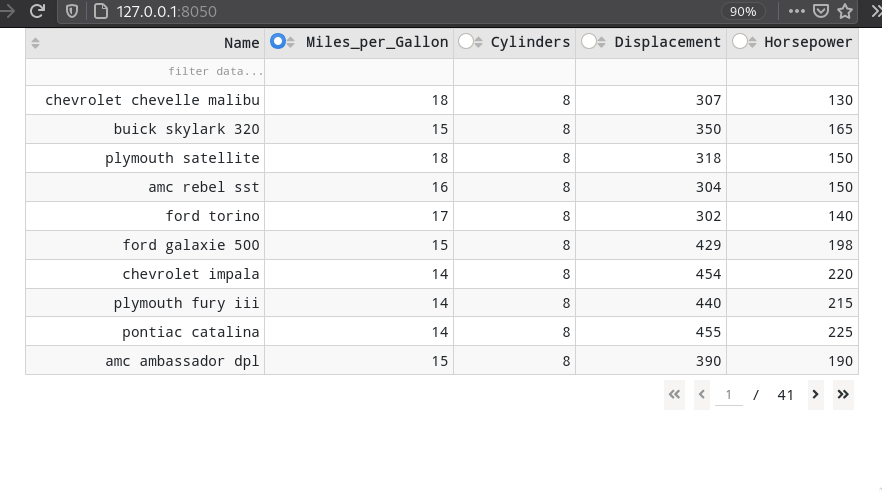

Our entire app now looks like this:

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]],  
                data=cars.to_dict('records'),
                sort_action="native",
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size=10,
                filter_action='native',
                style_cell={'padding': '5px'},
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}
            ),
        ])
    ])
)

if __name__ == '__main__':
    app.run_server(debug=True)
```

## Table callbacks

Tables have several emitted signals/events that we can listen for,
the most relevant in our case are the rows which change when we filter,
and the column that is selected.
First we add an empty div as a placeholder for the output area,
but we will not use it in the beginning.
Instead,
let's just print the value
which will show you that a list of columns is always returned.

```python
@app.callback(
    Output('output-div', "children"),
    Input('table', "selected_columns"))
def update_graphs(selected_column):
    print(selected_column)
```

The other intersting signal,
the rows of the table,
are a bit more cryptically named (`'derived_virtual_data'`).

```python
@app.callback(
    Output('output-div', "children"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_graphs(rows, selected_column):
    print(rows)
```

When we print the `rows`, 
you can see that the format is a list with one dictionary per row.
To get this back to a dataframe,
we will use `pd.DataFrame(rows)`.
If you try filtering,
you will see that fewer rows are returned here.

## Controlling plots from the table callback

We can now use these callbacks to drive plotting events,
just as we would have if we had used a dash core components widget.
The following would plot a histogram of the selected column and the filtered data points:

```python
# An Iframe with the 'histogram' ID is also needed

@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_graphs(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    return chart.to_html()
```

Here is the entire app when plotting both a histogram and scatter plot
based on the state of the table.

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_html_components as html
from dash.dependencies import Output, Input
import pandas as pd
import altair as alt
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(
                id='table',
                columns=[{"name": col, "id": col, 'selectable': True if col != 'Name' else False} for col in cars.columns[:5]], 
                data=cars.to_dict('records'),
                style_cell={'padding': '5px'},
                sort_action="native",
                page_action='native',
                column_selectable="single",
                selected_columns=['Miles_per_Gallon'], 
                page_size= 10,
                filter_action='native',
                style_data_conditional=[{
                    'if': {'row_index': 'odd'},
                    'backgroundColor': 'rgb(248, 248, 248)'}],
                 style_header={
                    'backgroundColor': 'rgb(230, 230, 230)',
                    'fontWeight': 'bold'}),
            html.Div(id='output-div'),
            html.Iframe(
                id='histogram',
                style={'border-width': '0', 'width': '100%', 'height': '400px'}
            )
        ])
    ])
)

@app.callback(
    Output('histogram', "srcDoc"),
    Input('table', "derived_virtual_data"),
    Input('table', "selected_columns"))
def update_graphs(rows, selected_column):
    chart = alt.Chart(pd.DataFrame(rows)).mark_bar().encode(
        alt.X(selected_column[0], bin=True),
        alt.Y('count()'))
    chart2 = alt.Chart(pd.DataFrame(rows)).mark_point().encode(
        alt.X(selected_column[0]),
        alt.Y('Horsepower'),
        tooltip='Name')
    return (chart | chart2).to_html()

if __name__ == '__main__':
    app.run_server(debug=True
```

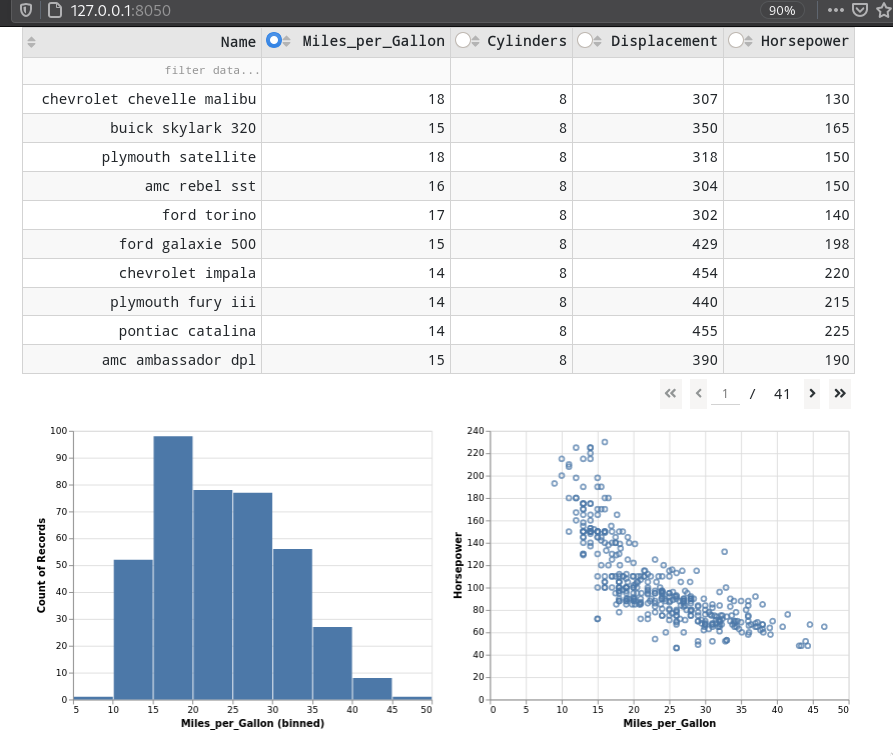

## Updating a table based on a callback

For callbacks from other widgets or from plotly plots,
you can treat tables as any other output element
and target their `columns` and `data` attributes to update them
via a callback function.

```python
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_core_components as dcc
from dash.dependencies import Output, Input
from vega_datasets import data


cars = data.cars()

app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

app.layout = dbc.Container(
    dbc.Row([
        dbc.Col([
            dash_table.DataTable(id='table', page_size=5),
            dcc.Dropdown(
                id='dropdown',
                options=[{"label": col, "value": col} for col in cars.columns],
                multi=True,
                value=['Horsepower']
            ),
        ])
    ])
)

@app.callback(
    Output('table', 'data'),
    Output('table', 'columns'),
    Input('dropdown', 'value'))
def update_table(cols):
    columns=[{"name": col, "id": col} for col in cols]
    data=cars[cols].to_dict('records')
    return data, columns

if __name__ == '__main__':
    app.run_server(debug=True)
```

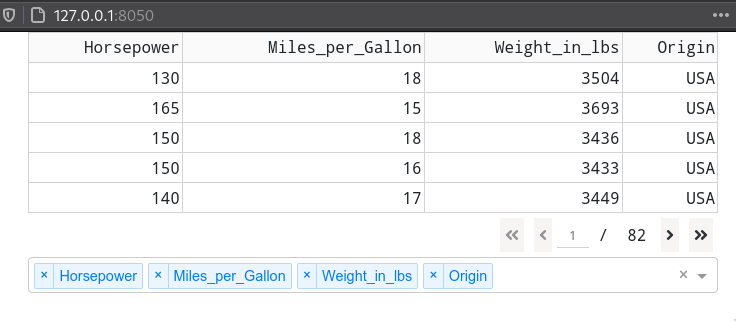

### Updating a table from an Altair plot

From altair plots,
there is no way to update a dash table,
but if you just need to show a few numbers based on a plot selection,
you can [use `mark_text()`
to update a plot area that looks like a table](https://altair-viz.github.io/gallery/scatter_linked_table.html).

In [25]:
import altair as alt
from vega_datasets import data

source = data.cars()

# Brush for selection
brush = alt.selection(type='interval')

# Scatter Plot
points = alt.Chart(source).mark_point().encode(
    x='Horsepower:Q',
    y='Miles_per_Gallon:Q',
    color=alt.condition(brush, alt.value('steelblue'), alt.value('grey'))
).add_selection(brush)

# Base chart for data tables
ranked_text = alt.Chart(source).mark_text(align='right').encode(
    y=alt.Y('row_number:O',axis=None)
).transform_window(
    row_number='row_number()'
).transform_filter(
    brush
).transform_window(
    rank='rank(row_number)'
).transform_filter(
    alt.datum.rank<16
)

# Data Tables
horsepower = ranked_text.encode(text='Horsepower:N').properties(title=alt.TitleParams(text='Horsepower', align='right'))
mpg = ranked_text.encode(text='Miles_per_Gallon:N').properties(title=alt.TitleParams(text='MPG', align='right'))
origin = ranked_text.encode(text='Origin:N').properties(title=alt.TitleParams(text='Origin', align='right'))
text = alt.hconcat(horsepower, mpg, origin) # Combine data tables

# Build chart
alt.hconcat(
    points,
    text
).resolve_legend(
    color="independent"
).configure_view(strokeWidth=0)

alt.HConcatChart(...)